# JETSCAPE Summer School 2022: 
## Bayesian parameter inference for a **relativistic heavy ion collision model**.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import GPy
import sys
import os
import pickle
import math

import matplotlib, matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv
import h5py
import seaborn as sns
import pandas as pd
import scipy.stats as st
from scipy import optimize
from scipy.linalg import lapack

import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl


import emcee # For MCMC
import ptemcee # For Parallel tempered MCMC
#from emcee import PTSampler


from multiprocessing import Pool
from multiprocessing import cpu_count

import time
sns.set("notebook")

# check if you can load the pregenerated emulators:
with open("./DataFiles/PbPb2760_emulators_scikit.dat","rb") as f:
    _ = pickle.load(f)
del _

In [3]:
from collections import OrderedDict

colors = OrderedDict([
    ('blue', '#4e79a7'),
    ('orange', '#f28e2b'),
    ('green', '#59a14f'),
    ('red', '#e15759'),
    ('cyan', '#76b7b2'),
    ('purple', '#b07aa1'),
    ('brown', '#9c755f'),
    ('yellow', '#edc948'),
    ('pink', '#ff9da7'),
    ('gray', '#bab0ac')
])

fontsize = dict(
    large=11,
    normal=10,
    small=9,
    tiny=8
)

offblack = '.15'

plt.rcdefaults()
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Lato'],
    'mathtext.fontset': 'custom',
    'mathtext.default': 'it',
    'mathtext.rm': 'sans',
    'mathtext.it': 'sans:italic:medium',
    'mathtext.cal': 'sans',
    'font.size': fontsize['normal'],
    'legend.fontsize': fontsize['normal'],
    'axes.labelsize': fontsize['normal'],
    'axes.titlesize': fontsize['large'],
    'xtick.labelsize': fontsize['small'],
    'ytick.labelsize': fontsize['small'],
    #'font.weight': 400,
    'axes.labelweight': 400,
    'axes.titleweight': 400,
    'axes.prop_cycle': plt.cycler('color', list(colors.values())),
    'lines.linewidth': .8,
    'lines.markersize': 3,
    'lines.markeredgewidth': 0,
    'patch.linewidth': .8,
    'axes.linewidth': .6,
    'xtick.major.width': .6,
    'ytick.major.width': .6,
    'xtick.minor.width': .4,
    'ytick.minor.width': .4,
    'xtick.major.size': 3.,
    'ytick.major.size': 3.,
    'xtick.minor.size': 2.,
    'ytick.minor.size': 2.,
    'xtick.major.pad': 3.5,
    'ytick.major.pad': 3.5,
    'axes.labelpad': 4.,
    'axes.formatter.limits': (-5, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'text.color': offblack,
    'axes.edgecolor': offblack,
    'axes.labelcolor': offblack,
    'xtick.color': offblack,
    'ytick.color': offblack,
    'legend.frameon': False,
    'image.cmap': 'Blues',
    'image.interpolation': 'none',
})

def set_tight(fig=None, **kwargs):
    """
    Set tight_layout with a better default pad.

    """
    if fig is None:
        fig = plt.gcf()

    kwargs.setdefault('pad', .1)
    fig.set_tight_layout(kwargs)

In [4]:
name="JETSCAPE_bayes"
#Saved emulator name
EMU='PbPb2760_emulators_scikit.dat'
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

# Define folder structure 

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

We will perform a Bayesian Parameter Inference similar to that in the published paper by **Derek Everett** and the JETSCAPE collaborators (2021):
- [Multi-system Bayesian constraints on the transport coefficients of QCD matter](https://arxiv.org/abs/2011.01430), [Phys. Rev. C 103, 054904 (2021)](https://journals.aps.org/prc/abstract/10.1103/PhysRevC.103.054904).
- [Phenomenological constraints on the transport properties of QCD matter with data-driven model averaging](https://arxiv.org/abs/2010.03928), [Phys. Rev. Lett. 126, 242301 (2021)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.126.242301).

In the paper they consider multiple choices of particularization models and used both RHIC and LHC data. But in this hands-on session, to keep things simple, we will limit to one model and only the LHC experimental data. 

### JETSCAPE framework for the evolution of the medium in high-energy nuclear collisions

![Different stages of relativistic heavy ion collision](IllustrationFigs/JETSCAPE.png)

### What's in This Notebook

**0. The Piror**
   - Understand the meaning of the parameters and the prior range of varaiation.
   - What happens if we restricted a few prior parameters (in the end).

**1. Simulation data**
   - Load saved simulation data from a folder. Anyone who wish to use the code to do another Bayesian analysis for relativistic heavy ion collision should do minor change to this section that suits their model and simulation data.
            --Python modules used
               - pandas
    
**2. Data preprocessing**
   - Standardize observables by removing the mean and scaling to unit variance. 
   - Dimensionality reduction of the data using the Principal Component Analysis (PCA).
             --Python modules used
                - numpy, sklearn
                
**3. Experimental data**
   - Relevant experimental data is also loaded from disk.
   - Compare prior samples of observables to the experimental data.
            --Python modules used
                - pandas

**4. Building Emulators**
   - Since the simulations are computationally expensive, we need surrogate models that can be trained on a sparse set of simulation data obtained from the full model.
   - Train Gaussian Process Emulators (GP) for each principal component (truncated). Construct the surrogate model "GP+inverse PCA" to fast interpolate model calculations with emulator uncertainties.
   - Validate the emulators.
            --Python modules used
                - sklearn Gaussian Processors, numpy
                
**5. Bayesian Parameter Estimation**
   - The Bayes theorem is used to define the posterior of the model parameters using the emulators and the experimental data.
   - Random samples are drawn from the high-dimensional posterior using Markov Chain Monte Carlo (MCMC) method.
   - Study the posterior viscosity and observables.
            --Python modules used
                - pandas, numpy, seaborn

## I. Understanding the Prior

JETSCAPE model parameters and prior range of individual parameters

![Model parameters](IllustrationFigs/JS-prior.png)

Eight of these parameters are related to the temperature-dependent shear and bulk viscosity

In [5]:
@np.vectorize
def zeta_over_s(T, zmax, T0, width, asym):
    DeltaT = T - T0
    sign = 1 if DeltaT>0 else -1
    x = DeltaT/(width*(1.+asym*sign))
    return zmax/(1.+x**2)

@np.vectorize
def eta_over_s(T, T_k, alow, ahigh, etas_k):
    if T < T_k:
        y = etas_k + alow*(T-T_k)
    else:
        y = etas_k + ahigh*(T-T_k)
    if y > 0:
        return y
    else:
        return 0.


### Exercise 1

What the prior of $\eta/s(T)$ and $\zeta/s(T)$ look like, assuming $T_\eta, (\eta/s)_{\rm kink}, a_{\rm low}, a_{\rm high}$ and $(\zeta/s)_{\rm max}, T_\zeta, w_\zeta, \lambda_\eta$ are pulled from independent uniform distribution?

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


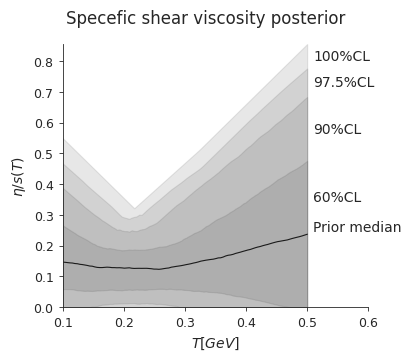

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3.5),
                         sharex=False, sharey=False, constrained_layout=True)
fig.suptitle("Specefic shear viscosity posterior", wrap=True)
ax.set_xlabel(r'$T [GeV]$')
ax.set_ylabel(r'$\eta/s(T)$')

u4 = np.random.rand(4, 1000)
Tk    =  0.13 * (1.-u4[0]) + 0.3 * u4[0]
alow  = - 2.0 * (1.-u4[1]) + 1.0 * u4[1] 
ahigh = - 1.0 * (1.-u4[2]) + 2.0 * u4[2] 
etask =  0.01 * (1.-u4[3]) + 0.2 * u4[3] 

T = np.linspace(0.1, 0.5, 100)
ax.set_xlim(0.1, 0.6)

etas_samples = np.array([eta_over_s(it, Tk, alow, ahigh, etask) for it in T]).T
ax.set_ylim(0,np.max(etas_samples))

prior_median = np.percentile(etas_samples, 50, axis=0)
ax.plot(T, prior_median, 'k-')

_ = prior_median.max()
ax.annotate('Prior median', xy=(T[-1]*1.02, _), va="bottom", ha="left")
for CL in [60,90,97.5,100]:
    Low, High = np.percentile(etas_samples, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(T, Low, High, alpha=0.1, color='k')
    _ = (_ + High.max())/2.
    ax.annotate("{}%CL".format(CL), xy=(T[-1]*1.02, _), va="center", ha="left")
    _ = High.max()


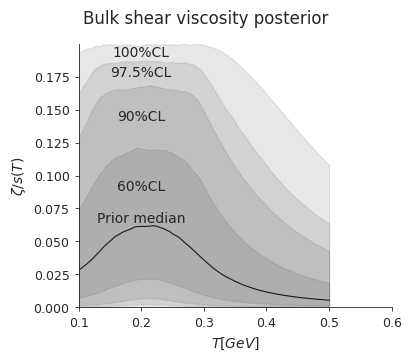

In [7]:
# Please repeat for bulk viscosity
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3.5),
                         sharex=False, sharey=False, constrained_layout=True)
fig.suptitle("Bulk shear viscosity posterior", wrap=True)
ax.set_xlabel(r'$T [GeV]$')
ax.set_ylabel(r'$\zeta/s(T)$')

u4 = np.random.rand(4, 10000)
zetasmax =  0.01 * (1.-u4[0]) + 0.2 * u4[0]
Tzeta  = 0.12 * (1.-u4[1]) + 0.3 * u4[1] 
wzeta = 0.025 * (1.-u4[2]) + 0.15 * u4[2] 
lambdazeta =  -0.8 * (1.-u4[3]) + 0.8 * u4[3] 

T = np.linspace(0.1, 0.5, 100)
ax.set_xlim(0.1, 0.6)

zetas_samples = np.array([zeta_over_s(it, zetasmax, Tzeta, wzeta, lambdazeta) for it in T]).T
ax.set_ylim(0,np.max(zetas_samples))

prior_median = np.percentile(zetas_samples, 50, axis=0)
ax.plot(T, prior_median, 'k-')

_ = prior_median.max()
ax.annotate('Prior median', xy=(.2, _), va="bottom", ha="center")
for CL in [60,90,97.5,100]:
    Low, High = np.percentile(zetas_samples, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(T, Low, High, alpha=0.1, color='k')
    _ = (_ + High.max())/2.
    ax.annotate("{}%CL".format(CL), xy=(.2, _), va="center", ha="center")
    _ = High.max()


### Are there any long-range correlations in the Prior?
For example, if we somehow use RHIC data to constrain $\eta/s$ to be within $0.15<\eta/s<0.2$ below $T=0.2$, does the prior become too restrictive at higher temperature that it may cause tension when new (e.g. LHC) data that are senstivie to higher temperature (e.g. 0.4 GeV) region are included?

In [8]:
cut = T<0.2
selected_samples = []
Thigh_samples = []
while len(Thigh_samples) < 2000:
    u = np.random.rand(4)
    Tk    =  0.13 * (1.-u[0]) + 0.3 * u[0]
    alow  = - 2.0 * (1.-u[1]) + 1.0 * u[1] 
    ahigh = - 1.0 * (1.-u[2]) + 2.0 * u[2] 
    etask =  0.01 * (1.-u[3]) + 0.2 * u[3] 
    it = eta_over_s(T, Tk, alow, ahigh, etask)
    if ( (0.15<it[cut]) & (it[cut]<0.2) ).all():
        Thigh_samples.append(eta_over_s([0.4], Tk, alow, ahigh, etask)[0])
        if np.random.rand()<.1:
            
            selected_samples.append(it)
selected_samples = np.array(selected_samples)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


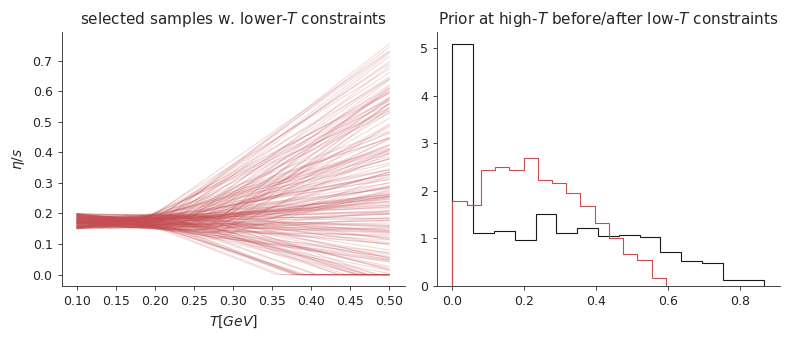

In [9]:
fig, (axL, axR) = plt.subplots(1,2, figsize=(8,3.5))

axL.set_title("selected samples w. lower-$T$ constraints")
axL.set_xlabel(r"$T [GeV]$")
axL.set_ylabel(r"$\eta/s$")
axL.plot(T, selected_samples.T, color='r', alpha=0.2)
        
axR.set_title("Prior at high-$T$ before/after low-$T$ constraints")
axR.hist(etas_samples[:,-1], bins=15, color='k', histtype='step', density=True)
axR.hist(Thigh_samples, bins=15, color='r', histtype='step', density=True)
plt.tight_layout()

### 1. Training data: designed inputs and model outputs

In [10]:
#Model parameter names in Latex compatble form
model_param_dsgn = ['$N$[$2.76$TeV]',
 '$p$',
 '$\\sigma_k$',
 '$w$ [fm]',
 '$d_{\\mathrm{min}}$ [fm]',
 '$\\tau_R$ [fm/$c$]',
 '$\\alpha$',
 '$T_{\\eta,\\mathrm{kink}}$ [GeV]',
 '$a_{\\eta,\\mathrm{low}}$ [GeV${}^{-1}$]',
 '$a_{\\eta,\\mathrm{high}}$ [GeV${}^{-1}$]',
 '$(\\eta/s)_{\\mathrm{kink}}$',
 '$(\\zeta/s)_{\\max}$',
 '$T_{\\zeta,c}$ [GeV]',
 '$w_{\\zeta}$ [GeV]',
 '$\\lambda_{\\zeta}$',
 '$b_{\\pi}$',
 '$T_{\\mathrm{sw}}$ [GeV]']

# Design points
design = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_design")
print("number of design & dimension of design", design.shape)
design.head()

number of design & dimension of design (485, 17)


,norm,trento_p,sigma_k,nucleon_width,dmin3,tau_R,alpha,eta_over_s_T_kink_in_GeV,eta_over_s_low_T_slope_in_GeV,eta_over_s_high_T_slope_in_GeV,eta_over_s_at_kink,zeta_over_s_max,zeta_over_s_T_peak_in_GeV,zeta_over_s_width_in_GeV,zeta_over_s_lambda_asymm,shear_relax_time_factor,Tswitch
0,15.81754,-0.06769,0.98153,0.92763,2.61235,1.34389,0.00988,0.21946,-0.28087,0.49299,0.10715,0.14627,0.19076,0.09729,0.15270,4.79271,0.14759
1,13.43970,0.12337,1.34278,1.10651,2.17324,0.90060,0.05149,0.23432,-0.37329,0.29940,0.08497,0.12393,0.20455,0.07722,0.29229,5.81536,0.14498
2,15.84174,0.13791,1.06155,1.15276,2.77641,1.03337,0.00518,0.23255,-0.35375,0.79445,0.13705,0.11665,0.18175,0.07408,0.07515,3.39156,0.15274
3,14.47395,0.11147,0.82684,1.01294,2.40816,1.13235,-0.08793,0.20885,-1.19838,0.43428,0.12346,0.07759,0.17377,0.06128,0.11686,4.61781,0.14550
4,16.13648,0.32229,1.38858,0.84729,1.23917,1.12739,-0.07829,0.23634,-0.22399,0.27735,0.14276,0.11019,0.20315,0.07877,-0.10924,6.42583,0.13879


## II. Experimental observables

   - Charged particle multiplicity $\frac{dN_{\rm ch}}{d\eta}$.
   - Transverse energy $\frac{dE_{\rm T}}{d\eta}$.
   - Identified particle yield and mean tranverse momentum $\frac{dN_{\pi, K, p}}{dy}, \langle p_{T}\rangle_{\pi, K, p}$.
   - Flow harmonics $\frac{dN}{d\phi} \propto 1 + \sum_n 2v_n \cos(n-\Psi_n)$.
   
       The observables are $v_n\{2\} = \sqrt{\langle v_n^2 \rangle}$: $v_2\{2\}, v_2\{3\}, v_2\{4\}$
       
   - Charged-particle mean-$p_T$ event-by-event flucutations
       $\frac{\delta\langle p_T\rangle}{\langle p_T\rangle}$

![Different stages of relativistic heavy ion collision](IllustrationFigs/inversion-problem-1.png)

In [11]:
experiment=pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_experiment",index_col=0)
experiment.head()
y_exp=experiment.loc['mean'].values
y_exp_variance=experiment.loc['variance'].values
print(f'Shape of the experiment observables {y_exp.shape} and shape of the experimental error variance{y_exp_variance.shape}')

Shape of the experiment observables (110,) and shape of the experimental error variance(110,)


In [12]:
# 8 bins
ALICE_cent_bins = np.array([[0,5],[5,10],[10,20],[20,30],[30,40],[40,50],[50,60],[60,70]]) 

obs_cent_list = {
'Pb-Pb-2760': {
    'dNch_deta' : ALICE_cent_bins,
    'dET_deta' : np.array([[0, 2.5], [2.5, 5], [5, 7.5], [7.5, 10],
                           [10, 12.5], [12.5, 15], [15, 17.5], [17.5, 20],
                           [20, 22.5], [22.5, 25], [25, 27.5], [27.5, 30],
                           [30, 32.5], [32.5, 35], [35, 37.5], [37.5, 40],
                           [40, 45], [45, 50], [50, 55], [55, 60],
                           [60, 65], [65, 70]]), # 22 bins
    'dN_dy_pion'   : ALICE_cent_bins,
    'dN_dy_kaon'   : ALICE_cent_bins,
    'dN_dy_proton' : ALICE_cent_bins,
    'dN_dy_Lambda' : np.array([[0,5],[5,10],[10,20],[20,40],[40,60]]), # 5 bins
    'dN_dy_Omega'  : np.array([[0,10],[10,20],[20,40],[40,60]]), # 4 bins
    'dN_dy_Xi'     : np.array([[0,10],[10,20],[20,40],[40,60]]), # 4 bins
    'mean_pT_pion'   : ALICE_cent_bins,
    'mean_pT_kaon'   : ALICE_cent_bins,
    'mean_pT_proton' : ALICE_cent_bins,
    'pT_fluct' : np.array([[0,5],[5,10],[10,15],[15,20], [20,25],[25,30],[30,35],[35,40], [40,45],[45,50],[50,55],[55,60]]), #12 bins
    'v22' : ALICE_cent_bins,
    'v32' : np.array([[0,5],[5,10],[10,20],[20,30], [30,40],[40,50]]), # 6 bins
    'v42' : np.array([[0,5],[5,10],[10,20],[20,30], [30,40],[40,50]]), # 6 bins
    }
}

obs_groups = {'yields' : ['dNch_deta', 'dET_deta', 'dN_dy_pion', 'dN_dy_kaon', 'dN_dy_proton'],
              'mean_pT' : ['mean_pT_pion', 'mean_pT_kaon','mean_pT_proton', ],
              'fluct' : ['pT_fluct'],
              'flows' : ['v22', 'v32', 'v42']}

obs_group_labels = {'yields' : r'$dN_\mathrm{id}/dy_p$, $dN_\mathrm{ch}/d\eta$, $dE_T/d\eta$ [GeV]',
                    'mean_pT' : r'$ \langle p_T \rangle_\mathrm{id}$' + ' [GeV]',
                    'fluct' : r'$\delta p_{T,\mathrm{ch}} / \langle p_T \rangle_\mathrm{ch}$',
                    'flows' : r'$v^{(\mathrm{ch})}_k\{2\} $'}

colors = ['b', 'g', 'r', 'c', 'm', 'tan', 'gray']

obs_tex_labels = {'dNch_deta' : r'$dN_\mathrm{ch}/d\eta$' + ' x 2',
                  'dN_dy_pion' : r'$dN_{\pi}/dy_p$',
                  'dN_dy_kaon' : r'$dN_{K}/dy_p$',
                  'dN_dy_proton' : r'$dN_{p}/dy_p$',
                  'dET_deta' : r'$dE_{T}/d\eta$' + ' x 5',
                  
                  'mean_pT_proton' : r'$\langle p_T \rangle_p$',
                  'mean_pT_kaon' : r'$\langle p_T \rangle_K$',
                  'mean_pT_pion' : r'$\langle p_T \rangle_\pi$',
                 
                  'pT_fluct' : None,
                  'v22' : r'$v^{(\mathrm{ch})}_2\{2\}$',
                  'v32' : r'$v^{(\mathrm{ch})}_3\{2\}$',
                  'v42' : r'$v^{(\mathrm{ch})}_4\{2\}$'}

In [13]:
index={}
st_index=0
for obs_group in  obs_groups.keys():
    for obs in obs_groups[obs_group]:
        #print(obs)
        n_centrality= len(obs_cent_list['Pb-Pb-2760'][obs])
        #print(n_centrality)
        index[obs]=[st_index,st_index+n_centrality]
        st_index = st_index+n_centrality
print(index)

{'dNch_deta': [0, 8], 'dET_deta': [8, 30], 'dN_dy_pion': [30, 38], 'dN_dy_kaon': [38, 46], 'dN_dy_proton': [46, 54], 'mean_pT_pion': [54, 62], 'mean_pT_kaon': [62, 70], 'mean_pT_proton': [70, 78], 'pT_fluct': [78, 90], 'v22': [90, 98], 'v32': [98, 104], 'v42': [104, 110]}


No handles with labels found to put in legend.
 /usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:51: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


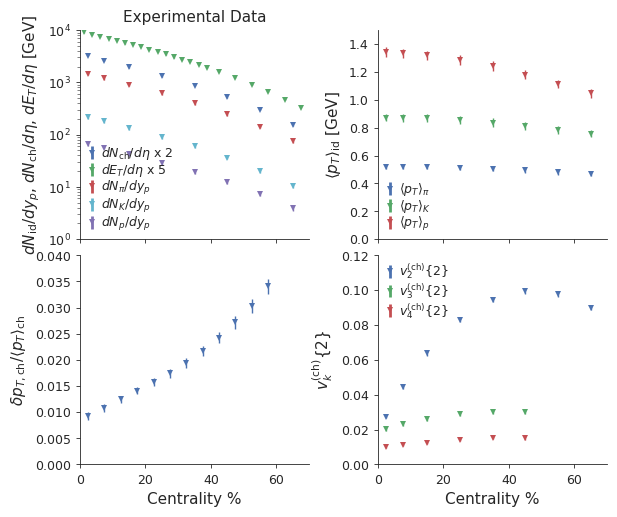

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 5), sharex=True)
axes = axes.flatten()

for row, obs_group in enumerate(obs_groups.keys()):
    for obs, color in zip(obs_groups[obs_group], colors):
        expt_label = 'ALICE'
        
        axes[row].tick_params(labelsize=9)

        scale = 1.0
        if obs_group == 'yields':
            axes[row].set_yscale('log')         
            axes[row].set_title("Experimental Data", fontsize = 11)
            if obs == 'dET_deta':
                scale = 5.
            if obs == 'dNch_deta':
                scale = 2.
        
        axes[row].set_ylabel(obs_group_labels[obs_group], fontsize = 11)
        
        xbins = np.array(obs_cent_list['Pb-Pb-2760'][obs])
        x = (xbins[:,0] + xbins[:,1]) / 2.

        label = obs_tex_labels[obs]
            
    
        exp_mean = y_exp[index[obs][0]:index[obs][1]]
        exp_err = np.sqrt(y_exp_variance[index[obs][0]:index[obs][1]])

        axes[row].errorbar(x, exp_mean*scale, exp_err, color=color, fmt='v', markersize='4', elinewidth=1, label=label)
 
        
    leg = axes[row].legend(fontsize=9, borderpad=0, labelspacing=0, handlelength=1, handletextpad=0.2)
    
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
        legobj.set_alpha(1.0)

    axes[row].set_xlim(0, 70)
    if obs_group == 'yields':
        axes[row].set_ylim(1, 1e4)
    if obs_group == 'mean_pT':
        axes[row].set_ylim(0., 1.5)
    if obs_group == 'fluct':
        axes[row].set_ylim(0.0, 0.04)
    if obs_group == 'flows':
        axes[row].set_ylim(0.0, 0.12)
    if axes[row].is_last_row():
        axes[row].set_xlabel('Centrality %', fontsize = 11)

plt.tight_layout(True)
set_tight(fig, rect=[0, 0, 1, 1])
save_fig("Experimental_data")

## III. Training data

Observables calculated from the physical model simulations at each of the design parameter set.


In [15]:
#Simulation outputs at the design points
simulation = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_simulation")
print("Number of physical evaluations, dimension of observable vector", simulation.shape)
simulation.head()

Number of physical evaluations, dimension of observable vector (485, 110)


,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],dET_deta[2.5 5. ],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,1608.155095,1301.879222,953.021576,645.307009,402.420100,244.321593,138.775810,64.998956,2094.094369,1854.027153,...,0.027231,0.030437,0.032241,0.034078,0.010554,0.012550,0.014681,0.017421,0.019349,0.018653
1,1376.107143,1141.792044,896.336877,634.080481,398.155003,253.422222,146.311755,75.674266,1718.904855,1568.418976,...,0.025072,0.025309,0.027655,0.025310,0.009541,0.009735,0.011988,0.012579,0.013068,0.012530
2,1715.649143,1410.970524,1075.089936,734.002033,495.888734,315.102365,182.456817,93.457043,2165.629760,1945.260785,...,0.020419,0.021284,0.021178,0.022446,0.008585,0.009366,0.008328,0.009645,0.010275,0.010419
3,1474.812429,1198.535444,919.375636,646.697544,439.662816,280.593073,160.003266,79.338320,1927.358731,1727.315725,...,0.019061,0.020970,0.024026,0.023602,0.007337,0.008606,0.010254,0.010787,0.012219,0.011568
4,1625.855467,1369.550286,1065.824673,726.855338,504.200066,322.735247,190.869785,100.375664,2156.410538,1920.777164,...,0.025223,0.028049,0.029004,0.029121,0.010363,0.011207,0.011285,0.012834,0.012702,0.014524


In [16]:
#Simulation outputs at the design points
validation = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_simulation_validation")
print("Number of physical evaluations, dimension of observable vector", validation.shape)
validation.head()

Number of physical evaluations, dimension of observable vector (100, 111)


,Unnamed: 0,dNch_deta[0 5],dNch_deta[ 5 10],dNch_deta[10 20],dNch_deta[20 30],dNch_deta[30 40],dNch_deta[40 50],dNch_deta[50 60],dNch_deta[60 70],dET_deta[0. 2.5],...,v32[10 20],v32[20 30],v32[30 40],v32[40 50],v42[0 5],v42[ 5 10],v42[10 20],v42[20 30],v42[30 40],v42[40 50]
0,0,1607.406827,1273.211081,894.816059,577.692590,381.786036,228.515895,124.108347,60.243908,2240.720043,...,0.029870,0.033726,0.033956,0.029849,0.013678,0.011257,0.016149,0.018677,0.022449,0.022658
1,1,1333.452143,1028.421424,742.935013,460.759269,270.425725,160.237382,85.543434,37.661492,1710.133926,...,0.019380,0.021844,0.020309,0.020310,0.005117,0.007442,0.009833,0.011052,0.012935,0.011795
2,2,1435.233929,1223.595389,973.246401,666.768340,463.441797,306.181273,187.000928,98.523180,1954.918039,...,0.028487,0.033219,0.031456,0.040168,0.011431,0.011307,0.013796,0.014428,0.017576,0.017510
3,3,1298.499992,1019.795576,739.553218,458.067706,273.882319,159.848093,71.506285,23.555752,1772.267689,...,0.033252,0.028571,0.030385,0.028741,0.011833,0.015531,0.015431,0.018261,0.022015,0.020972
4,4,1514.742262,1241.002222,955.723036,664.172542,444.300228,282.468266,151.528267,83.177199,2116.214094,...,0.025884,0.027797,0.032111,0.035275,0.012492,0.014350,0.015257,0.015620,0.017015,0.017321


In [17]:
# Design points
design_validation = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_2760_validation_design")
print("number of design & dimension of design", design_validation.shape)
design_validation.head()

number of design & dimension of design (100, 18)


,idx,norm,trento_p,sigma_k,nucleon_width,dmin3,tau_R,alpha,eta_over_s_T_kink_in_GeV,eta_over_s_low_T_slope_in_GeV,eta_over_s_high_T_slope_in_GeV,eta_over_s_at_kink,zeta_over_s_max,zeta_over_s_T_peak_in_GeV,zeta_over_s_width_in_GeV,zeta_over_s_lambda_asymm,shear_relax_time_factor,Tswitch
0,0,16.61392,-0.61335,1.17739,0.98622,1.24173,1.34216,0.11881,0.22059,-0.68223,0.24863,0.11678,0.10846,0.14633,0.09276,0.16548,4.48798,0.15136
1,1,11.61248,-0.30146,0.87235,1.11825,1.29157,1.68622,0.01821,0.18231,-0.99405,0.95749,0.17885,0.13953,0.17479,0.10002,-0.23630,4.55209,0.15316
2,2,14.69276,0.50810,0.85910,0.61338,1.14017,1.03135,-0.09393,0.21714,-1.07597,0.63656,0.10159,0.10165,0.24848,0.08054,0.12548,6.08133,0.15473
3,3,13.41240,-0.53809,1.73927,0.81786,2.32981,1.82643,-0.05917,0.18393,0.16338,1.01427,0.14438,0.12449,0.16211,0.10141,0.28260,5.04272,0.15018
4,4,15.71910,0.05154,0.48697,0.95485,1.44232,1.23290,0.08224,0.26589,-0.18979,0.85671,0.08464,0.11702,0.23338,0.07929,0.36065,4.58853,0.14579


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
 /usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


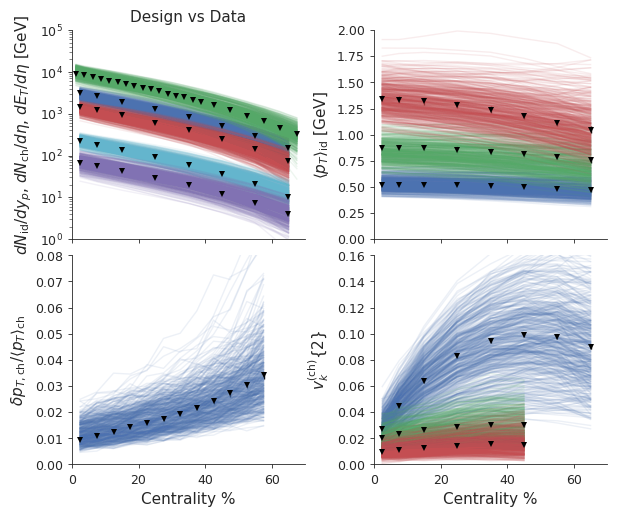

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 5), sharex=True)
axes =  axes.flatten()
for row, obs_group in enumerate(obs_groups.keys()):
    for obs, color in zip(obs_groups[obs_group], colors):
        expt_label = 'ALICE'
        
        axes[row].tick_params(labelsize=9)

        scale = 1.0
        if obs_group == 'yields':
            axes[row].set_yscale('log')
            axes[row].set_title("Design vs Data", fontsize = 11)          
            if obs == 'dET_deta':
                scale = 5.
            if obs == 'dNch_deta':
                scale = 2.
        
        axes[row].set_ylabel(obs_group_labels[obs_group], fontsize = 11)
        
        xbins = np.array(obs_cent_list['Pb-Pb-2760'][obs])
        x = (xbins[:,0] + xbins[:,1]) / 2.

        for i in range(simulation.shape[0]):
            Y1 = simulation.iloc[i,index[obs][0]:index[obs][1]]
            axes[row].plot(x, Y1*scale, color=color, lw=1, alpha=.1)
        label = obs_tex_labels[obs]           
       

        exp_mean = y_exp[index[obs][0]:index[obs][1]]
        exp_err = np.sqrt(y_exp_variance[index[obs][0]:index[obs][1]])

        axes[row].errorbar(x, exp_mean*scale, exp_err, color='black', fmt='v', markersize='4', elinewidth=1)
        
    leg = axes[row].legend(fontsize=9, borderpad=0, labelspacing=0, handlelength=1, handletextpad=0.2)
    
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
        legobj.set_alpha(1.0)

    axes[row].set_xlim(0, 70)

    if obs_group == 'yields':
        axes[row].set_ylim(1, 1e5)
    if obs_group == 'mean_pT':
        axes[row].set_ylim(0., 2)
    if obs_group == 'fluct':
        axes[row].set_ylim(0.0, 0.08)
    if obs_group == 'flows':
        axes[row].set_ylim(0.0, 0.16)
    if axes[row].is_last_row():
        axes[row].set_xlabel('Centrality %', fontsize = 11)

plt.tight_layout(True)
set_tight(fig, rect=[0, 0, 1, 1])
save_fig("Design-vs-Data")

As a necessary (but not always sufficient) condiiton, one should alwasy makesure that the traning data provide a good coverage of the experimental data. 
   - If not, then the model emulator will not have a good predictive power (good control of uncertainty) to analyze the model's behavior in the parameter regions that describes the data.
   - However, even if there is a good "coverage", it is possible that due to correlation among different obserable, there are still tensions in simultaneously descrbining all of them.

## IV. Statistical Analysis Begins Here

### Step 1: Training data preprocessing

In [19]:
# Summarize the tranining data: design inputs and observables
X = design.values
Y = simulation.values
print( "Dims of design (X)"+ str(X.shape) )
print( "Dims of output observables (Y) at these design: "+ str(Y.shape) )

Dims of design (X)(485, 17)
Dims of output observables (Y) at these design: (485, 110)


We have 485 sets of 110 observables, with different obervables have drastically magnitude.
For example, $\frac{dN_{\rm ch}}{d\eta} = 10^{3\sim 4}, v_2 = 0.01\sim0.1$. We will standardlize each observable by removing the mean and devide the standard deviation:

$${\rm O'} = \frac{O - \bar{\rm O}}{\sqrt{\bar{\rm O^2}-\bar{O}^2}}$$

where the "bar" stands for averging over the use of different sets of training data.


In [20]:
#Scaling the data to be zero mean and unit variance for each observables
SS  =  StandardScaler(copy=True)

### Step 2: Dimensional Reduction of the Observables via the Principal Component Analysis (PCA)

Discussion:
   - Is it alwasy necessary?
   - What's the different between 
      - 1) Directly train emulators on each individual observables;
      - 2) Use PCA, and training emulators on each PC;
      - 3) Use PCA, and training emulators on a truncated set of PC?
   - How many Principal Components should we keep (truncation)?
      - 1) Accuracy, how to estimate the performance of the truncated emualtor?
      - 2) Efficiency. How does the time complexity rest of the analysis scales with $N_{\rm pc}$?

In [21]:
#Singular Value Decomposition
u, s, vh = np.linalg.svd(SS.fit_transform(Y), full_matrices=True)
print(f'shape of u {u.shape} shape of s {s.shape} shape of vh {vh.shape}')

shape of u (485, 485) shape of s (110,) shape of vh (110, 110)


 /usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


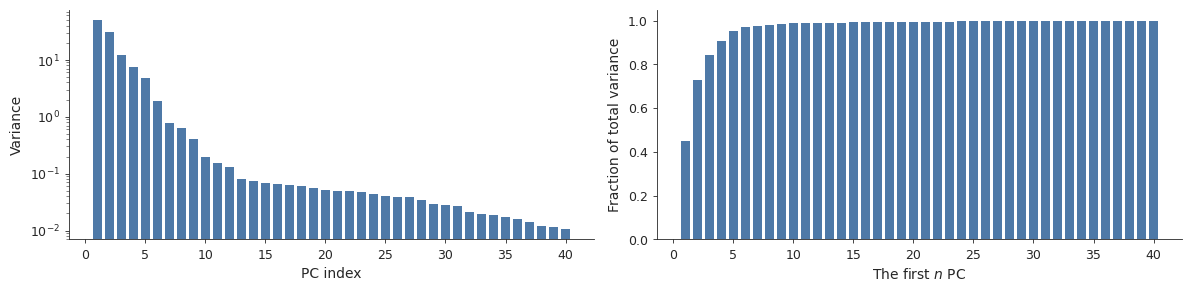

In [22]:
# print the explained raito of variance
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,3))
#importance = pca_analysis.explained_variance_
importance = np.square(s[:40]/math.sqrt(u.shape[0]-1))
cumulateive_importance = np.cumsum(importance)/np.sum(importance)
idx = np.arange(1,1+len(importance))
ax1.bar(idx,importance)
ax1.set_xlabel("PC index")
ax1.set_ylabel("Variance")
ax1.semilogy()
ax2.bar(idx,cumulateive_importance)
ax2.set_xlabel(r"The first $n$ PC")
ax2.set_ylabel("Fraction of total variance")
plt.tight_layout(True)

Discussion:
   - I have put the importance/variance of the PCs in log scale. Can you understand the "kink" feature around index=13? What caused this transition?
   - What does this suggests for you maximum possible number of PCs to be included in your emulator traning?

In [23]:
#whiten and project data to principal component axis (only keeping first 10 PCs)
Npc = 15
pc_tf_data=u[:,:Npc] * math.sqrt(u.shape[0]-1)

### 3. Load priors and experimental data.

In [24]:
# Bounds for parametrs in the emulator are same as prior ranges so
prior_df = pd.read_csv(filepath_or_buffer="DataFiles/PbPb2760_prior", index_col=0)

In [25]:
prior_df.head()

,norm,trento_p,sigma_k,nucleon_width,dmin3,tau_R,alpha,eta_over_s_T_kink_in_GeV,eta_over_s_low_T_slope_in_GeV,eta_over_s_high_T_slope_in_GeV,eta_over_s_at_kink,zeta_over_s_max,zeta_over_s_T_peak_in_GeV,zeta_over_s_width_in_GeV,zeta_over_s_lambda_asymm,shear_relax_time_factor,Tswitch
min,10.0,-0.7,0.3,0.5,0.000,0.3,-0.3,0.13,-2.0,-1.0,0.01,0.01,0.12,0.025,-0.8,2.0,0.130
max,20.0,0.7,2.0,1.5,4.913,2.0,0.3,0.30,1.0,2.0,0.20,0.20,0.30,0.150,0.8,8.0,0.165


### 4. Building emulators

In [26]:
design_max=prior_df.loc['max'].values
design_min=prior_df.loc['min'].values

In [27]:
import time
design=X
overide=False
input_dim=len(design_max)
ptp = design_max - design_min
bound=zip(design_min,design_max)

if (os.path.exists(data_path(EMU))) and (overide==False):
    print('Saved emulators exists and overide is prohibited')
    with open(data_path(EMU),"rb") as f:
        Emulators = pickle.load(f)
        for i, GPR in enumerate(Emulators):
            print('>>> Print saved GP for PC # {}'.format(i))
            print(f'GPR score is {GPR.score(design, pc_tf_data[:,i])} ')
            print('Trained RBF params ', GPR.kernel_.get_params()['k1'])
            print('Trained White Kernel params', GPR.kernel_.get_params()['k2'])
            print(f'GPR log_marginal likelihood {GPR.log_marginal_likelihood()} \n')
else:
    Emulators = []
    for i in range(0,15):
        start_time = time.time()
        print('>>> Training GP for PC # {}'.format(i))
        kernel = 1 * krnl.RBF(length_scale=ptp,length_scale_bounds=np.outer(ptp, (.1, 1e2)))\
               + krnl.WhiteKernel(noise_level=.1, noise_level_bounds=(1e-4, 1e4))
        GPR=gpr(kernel=kernel,n_restarts_optimizer=5)
        GPR.fit(design, pc_tf_data[:,i].reshape(-1,1))
        print(f'GPR score is {GPR.score(design, pc_tf_data[:,i])} ')
        print('Trained RBF params ', GPR.kernel_.get_params()['k1'])
        print('Trained White Kernel params', GPR.kernel_.get_params()['k2'])
        print(f'GPR log_marginal likelihood {GPR.log_marginal_likelihood()} ')
        print("--- %s seconds --- \n" % (time.time() - start_time))
        Emulators.append(GPR)

if (overide==True) or not(os.path.exists(data_path(EMU))):
    with open(data_path(EMU),"wb") as f:
        pickle.dump(Emulators,f)

Saved emulators exists and overide is prohibited
>>> Print saved GP for PC # 0
GPR score is 0.9848529150671621 
Trained RBF params  2.75**2 * RBF(length_scale=[26.1, 2.49, 4.49, 3.01, 91.4, 3.99, 5.03, 0.476, 10.5, 7.34, 0.728, 0.487, 0.289, 2.15, 8.87, 176, 0.187])
Trained White Kernel params WhiteKernel(noise_level=0.0226)
GPR log_marginal likelihood 12.75084431076408 

>>> Print saved GP for PC # 1
GPR score is 0.9963432826057436 
Trained RBF params  2.43**2 * RBF(length_scale=[30.8, 7.66, 7.04, 2.41, 103, 3.58, 1.73, 0.783, 15.6, 9.74, 0.603, 0.303, 0.124, 0.337, 2.94, 327, 0.0737])
Trained White Kernel params WhiteKernel(noise_level=0.00848)
GPR log_marginal likelihood 56.21310457393713 

>>> Print saved GP for PC # 2
GPR score is 0.9966685479380939 
Trained RBF params  2.15**2 * RBF(length_scale=[24, 2.72, 3.27, 1.85, 53.3, 3.03, 1.57, 0.171, 5.68, 8.17, 0.394, 0.33, 0.182, 0.218, 3.12, 26.4, 0.0965])
Trained White Kernel params WhiteKernel(noise_level=0.0118)
GPR log_marginal li

In [28]:
Ntruncated = 12
#Scale Transformation from PC space to original data space
inverse_tf_matrix= np.diag(s[:Ntruncated]) @ vh[:Ntruncated,:] * SS.scale_.reshape(1,110)/ math.sqrt(u.shape[0]-1)

In [29]:
def predict_observables(model_parameters):
    """Predicts the observables for any model parameter value using the trained emulators.
    
    Parameters
    ----------
    Theta_input : Model parameter values. Should be an 1D array of 17 model parametrs.
    Return
    ------
    Mean value and full error covaraiance matrix of the prediction is returened. """
    
    mean=[]
    variance=[]
    theta=np.array(model_parameters).flatten()
    
    if len(theta)!=17:
        raise TypeError('The input model_parameters array does not have the right dimensions')
    else: 
        for i in range(0,Ntruncated):
            mn, std = Emulators[i].predict([theta], return_std=True)
            mean.append(mn[0])
            variance.append(std[0]**2)
    mean = np.array(mean)
    inverse_transformed_mean = mean.T @ inverse_tf_matrix + SS.mean_
    variance_matrix = np.diag(np.array(variance))
    inverse_transformed_variance=np.einsum('ik,kl,lj-> ij', inverse_tf_matrix.T, variance_matrix, inverse_tf_matrix, optimize=False)
    return inverse_transformed_mean[0], inverse_transformed_variance

### Homework Exercise
To keep this notebook short we have omitted some of the essential checks in any Bayesian Parameter Inference task. Can you try to build these steps on your own?
 - Emulator validation
 - Prior predictive checks
 - Closure test

### 5. Bayesian parameter inference

In [30]:
do_validation = True
validation_set = 0
Yexp = y_exp if not do_validation else validation.iloc[0].values[1:]
Yvar = y_exp_variance if not do_validation else Yexp**2/100.**2

In [31]:
# This is an uniform prior in the 17 parameters as is used in the two JETSCAPE publications.
# Howework: what happens if you use an informative prior?
# or an more restrictive prior
# for example: What if you are (somehow) extremely certain that the nucleon width should be around 0.5 fm.
def log_prior(model_parameters):
    """Evaluvate the prior at model prameter values. 
    If all parameters are inside bounds function will return 0 otherwise -inf"""
    X = np.array(model_parameters).reshape(1,-1)
    lower = np.all(X >= design_min)
    upper = np.all(X <= design_max)
    if (lower and upper):
        lp=0
    # lp = np.log(st.beta.pdf(X,5,1,dsgn_min_ut.reshape(1,-1),(dsgn_max_ut-dsgn_min_ut).reshape(1,-1))).sum()
    else:
        lp = -np.inf
    return lp

In [32]:
def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    #print(L.diagonal())
    #a=np.ones(len(L.diagonal()))*1e-10
    #print(a)
    #print(L)
    #L=L+np.diag(a)
    if np.all(L.diagonal()>0):
        return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()
    else:
        print(L.diagonal())
        raise ValueError(
            'L has negative values on diagonal {}'.format(L.diagonal())
        )

In [33]:
# Covariance truncation error from PC is not yet included
exp_var = np.diag(Yvar)

def log_like(model_parameters):
    mn, var = predict_observables(model_parameters)
    dy = mn - Yexp
    return mvn_loglike(dy, var + exp_var)

#### MCMC

Here we used the Parallel Tempering MCMC Algorithm ([Will Vousden, Will M. Farr, Ilya Mandel (2015)](https://arxiv.org/pdf/1501.05823.pdf)) as implemented in the (PT)EMCEE package ([Foreman-Mackey, Hogg, Lang & Goodman (2012)](https://arxiv.org/abs/1202.3665)).

The Parallel Tempering MCMC method creates a ladder of chains with different "temperature" (T) sampled according to 

$$ {\rm Posterior_i}(p|{\rm Exp}) = {\rm Likelihood}(p|{\rm Exp})^{1/T_i} \times {\rm Prior}(p)$$

The temperatures for each chain: 
$$1=T_0< T_1 < T_2 < \cdots T_n$$
The cold chain with $T_0=1$ is the target posterior function that we need. High-temperature chains flatten the strucutres of the (possibily high-correlated) likelihood function to fast explore the entire parameter space. Different chains exchange configurations with probability $\min\left\{1,\left(\frac{L_i}{L_j}\right)^{1/T_j-1/T_i}\right\}$.

In [37]:
# Here we actually perform the MCMC Sampling
fname = 'ptemcee-exp' if not do_validation else 'ptemcee-validation-{:d}'.format(validation_set)
filename = data_path(name + fname)
# 1. Define the parameters
run_mcmc = False
ntemps = 10
Tmax = 10

ndim = 17
nwalkers = ndim*10 # Typically 10*ndim
nburnin = 200 # The number of steps it takes for the walkers to thermalize
niterations= 1000 # The number of samples to draw once thermalized
nthin = 4 # Record every nthin-th iteration

nthreads = 1 # Easy parallelization! 

#min_theta = [1.625] # Lower bound for initializing walkers
#max_theta = [24.79] # Upper bound for initializing walkers

st = time.time()
if run_mcmc:

    # 2. Instantiate the sampler object with the parameters, data, likelihood, and prior.
    
    #sampler=PTSampler(ntemps, nwalkers, ndim, logl, logp, threads=nthreads, betas=betas)
    ptsampler_ex = ptemcee.Sampler(nwalkers, ndim, log_like, log_prior, ntemps, 
                                   threads=nthreads, Tmax=Tmax)

    # 3. Initialize the walkers at random positions in our 99% prior range
    pos0 = design_min + (design_max - design_min) * np.random.rand(ntemps, nwalkers, ndim)

    # 4. Run the sampler's burn-in iterations
    print("Running burn-in phase")
    for p, lnprob, lnlike in ptsampler_ex.sample(pos0, iterations=nburnin,adapt=True):
        pass
    ptsampler_ex.reset() # Discard previous samples from the chain, but keep the position
    et = time.time()
    print(f'Time for burn-in {et-st}')
    
    
    print("Running MCMC chains")
    # 5. Now we sample for nwalkers*niterations, recording every nthin-th sample
    for p, lnprob, lnlike in ptsampler_ex.sample(p, iterations=niterations, thin=nthin,adapt=True):
        pass 

    print('Done MCMC')

    mean_acc_frac = np.mean(ptsampler_ex.acceptance_fraction)
    print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
          f"(in total {nwalkers*niterations} steps)")
    
    
    et = time.time()
    print(f'Time it took to generate MCMC chain {et-st}')
    
    # We only analyze the zero temperature MCMC samples
    #np.save(name+'ptemcee', )
    # closure_ex_chain = ptsampler_ex.chain[0, :, :, :].reshape((-1, ndim))
    samples = ptsampler_ex.chain[0, :, :, :].reshape((-1, ndim))
    samples_df= pd.DataFrame(samples, columns=model_param_dsgn)
    samples_df.to_csv(filename)
else:
    print("Load pregenerated chain")
    samples_df = pd.read_csv(filename, index_col=0)
    


Load pregenerated chain


In [38]:
print(samples_df.shape)
samples_df.head()

(42500, 17)


,$N$[$2.76$TeV],$p$,$\sigma_k$,$w$ [fm],$d_{\mathrm{min}}$ [fm],$\tau_R$ [fm/$c$],$\alpha$,"$T_{\eta,\mathrm{kink}}$ [GeV]","$a_{\eta,\mathrm{low}}$ [GeV${}^{-1}$]","$a_{\eta,\mathrm{high}}$ [GeV${}^{-1}$]",$(\eta/s)_{\mathrm{kink}}$,$(\zeta/s)_{\max}$,"$T_{\zeta,c}$ [GeV]",$w_{\zeta}$ [GeV],$\lambda_{\zeta}$,$b_{\pi}$,$T_{\mathrm{sw}}$ [GeV]
0,16.724139,-0.314418,1.176001,0.995626,3.028564,1.278686,0.063266,0.181608,-1.299091,-0.253384,0.135744,0.112717,0.281131,0.092191,-0.740284,4.954232,0.155664
1,17.433706,-0.598375,1.259935,0.915039,4.072927,1.365167,0.003025,0.167758,-1.392434,1.368898,0.071820,0.095243,0.244354,0.098429,-0.481201,4.697654,0.161704
2,17.069121,-0.649892,1.263477,0.903377,1.145994,1.354331,0.168668,0.131307,-1.695861,0.581477,0.084798,0.152727,0.204779,0.113721,-0.683846,4.176796,0.144041
3,16.432999,-0.368650,1.063689,0.991185,2.975871,1.165370,0.257565,0.188107,-1.800429,-0.507213,0.092304,0.147513,0.229740,0.122167,0.004127,6.182537,0.145157
4,16.031455,-0.368844,1.127791,0.900258,2.256325,1.275147,0.034895,0.254255,-0.663409,1.129996,0.071788,0.115678,0.276375,0.088884,-0.798170,5.559915,0.156038


### Homework exercise
 - Can you perform some MCMC diagnostic tests that you know on these posterior chains?

### Posterior distributions

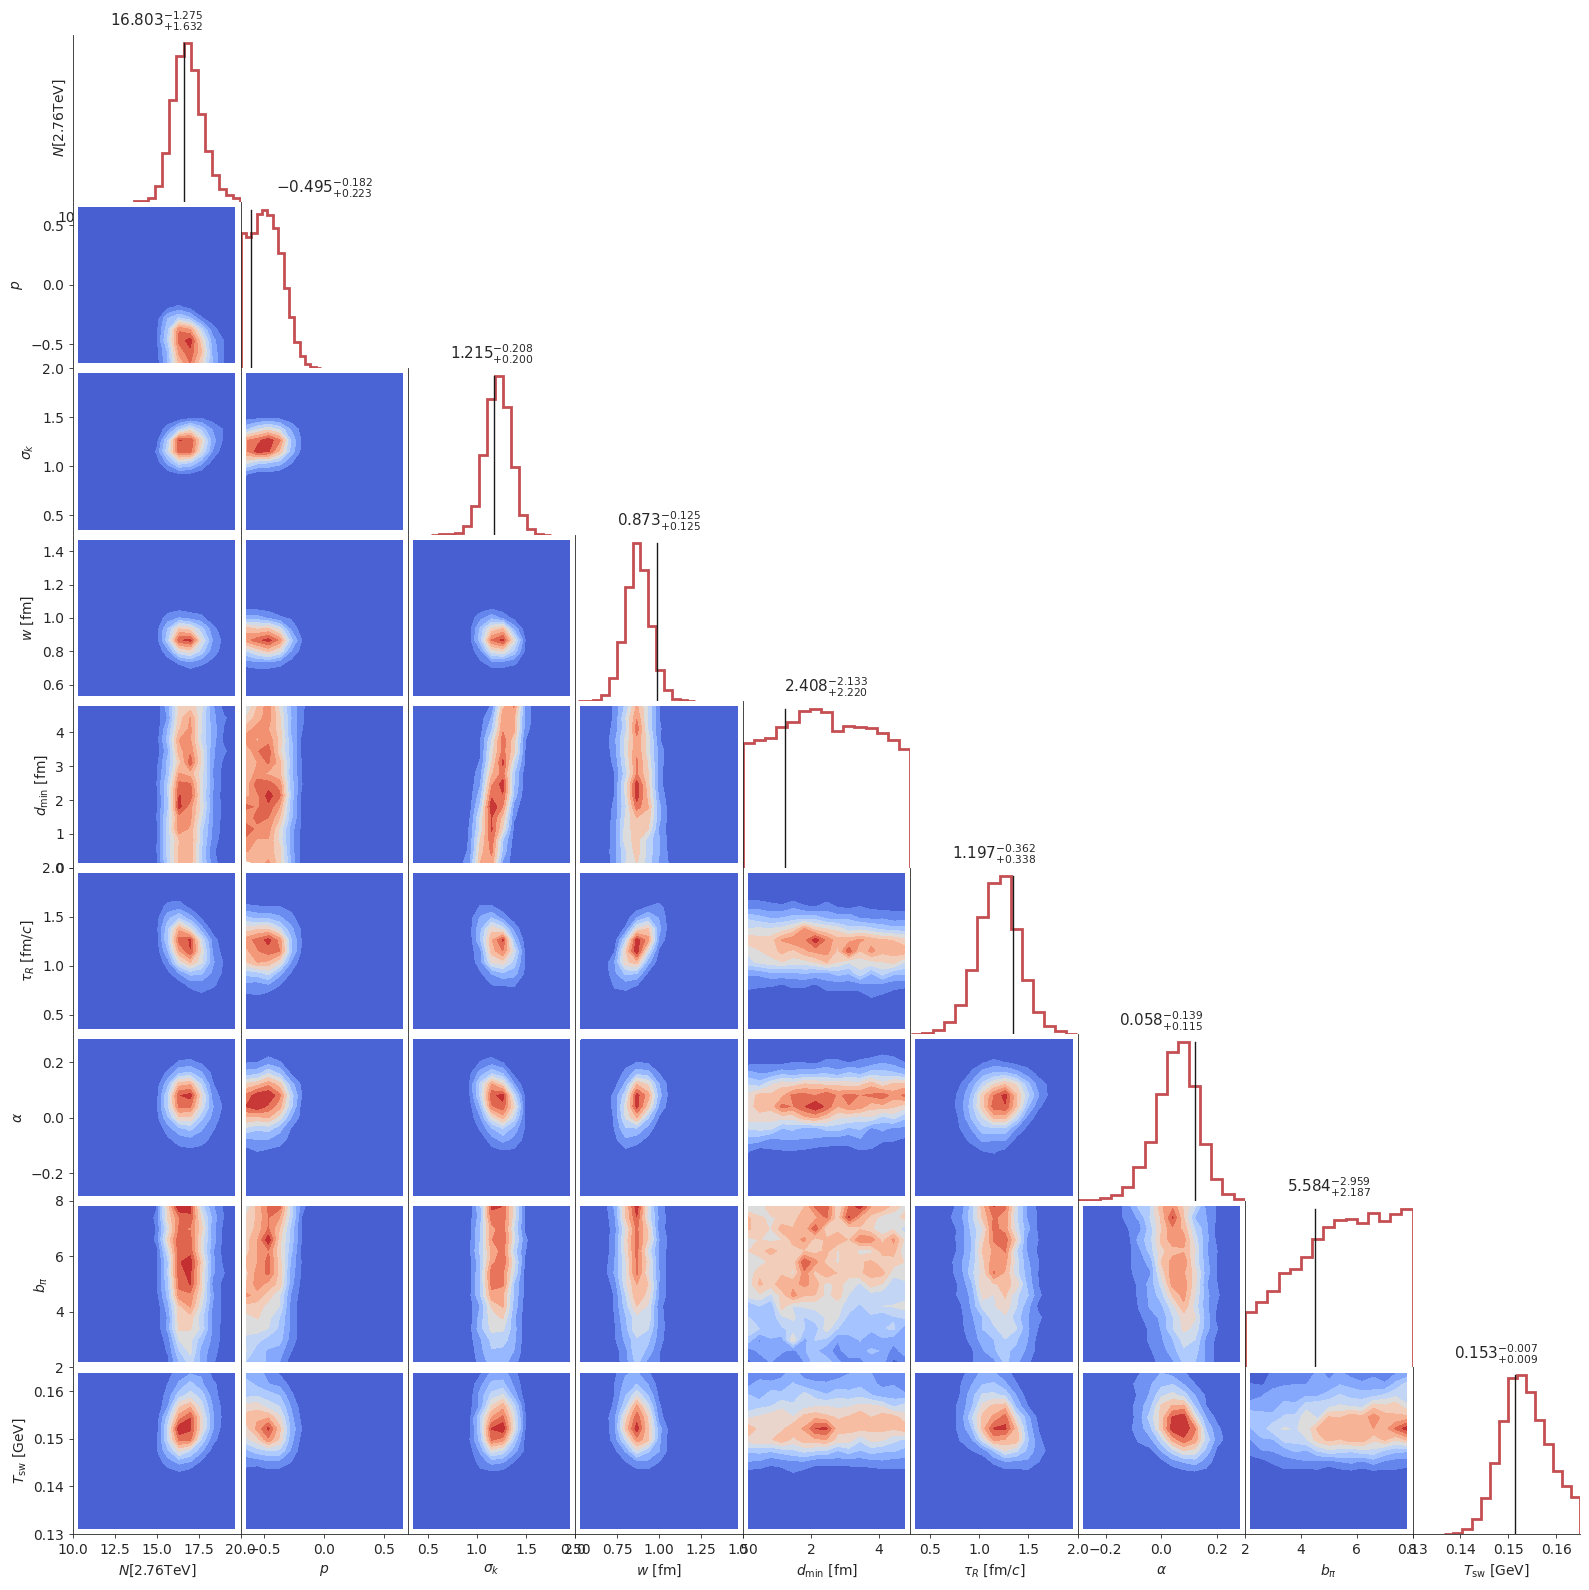

In [39]:
params_index_to_plot = [0, 1, 2 ,3 , 4, 5, 6, 15, 16]
nplots = len(params_index_to_plot)
fig, axes = plt.subplots(nplots,nplots,figsize=(16,16))

Truth = design_validation.iloc[validation_set][1:]

Nbins=15
# Diagonal: marginalized single-parameter posterior
for n,i in enumerate(params_index_to_plot):
    ax = axes[n][n]
    
    H, _, _ = ax.hist(samples_df.iloc[:,i], histtype='step', color='r', density=True, bins=Nbins, lw=2)
    x05, x50, x95 = np.quantile(samples_df.iloc[:,i], [.05, .5, .95])
    ax.set_title(r'${:.3f}^{{-{:.3f} }}_{{+{:.3f} }}$'.format(x50, x50-x05, x95-x50) )
    ax.tick_params(axis='both', labelsize=10)
    if do_validation:
        ax.plot([Truth[i], Truth[i]], [0,H.max()], 'k-', lw=1)
    ax.set_yticks([])
    ax.set_xlim(design_min[i], design_max[i] )
    axes[-1][n].set_xlabel(samples_df.columns[i])
    axes[n][0].set_ylabel(samples_df.columns[i])
    

# Off diagonal: marginalized two-parameter posterior
for n, i in enumerate(params_index_to_plot):
    ylim = design_min[i], design_max[i] 
    for m, j in enumerate(params_index_to_plot):
        ax = axes[n][m]
        xlim = design_min[j], design_max[j] 
        if n<m:
            ax.axis('off')
        if n>m:
            H, bx, by = np.histogram2d(samples_df.iloc[:,j], samples_df.iloc[:,i], range=(xlim,ylim), bins=Nbins)
            ax.contourf((bx[1:]+bx[:-1])/2., (by[1:]+by[:-1])/2., H.T, levels=10, cmap=plt.cm.coolwarm)
            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)
            if not ax.is_first_col():
                ax.set_yticks([])    
            if not ax.is_last_row():
                ax.set_xticks([])
            ax.tick_params(axis='both', labelsize=10)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
save_fig(name+"partial")
plt.show()

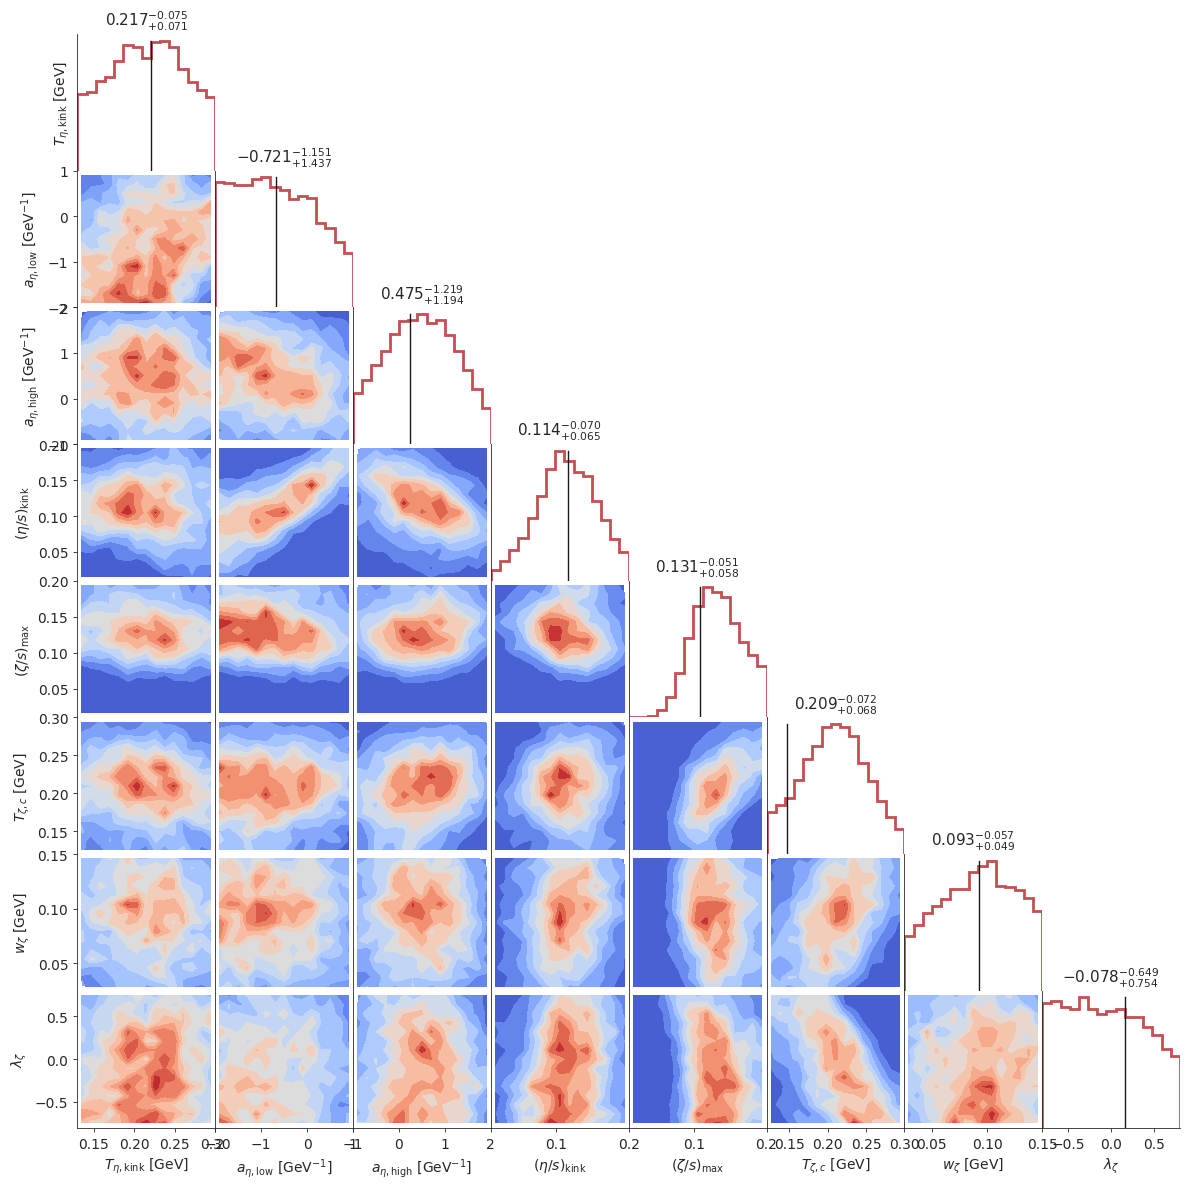

In [40]:

params_index_to_plot = [7,8,9,10,
                       11,12,13,14]
nplots = len(params_index_to_plot)
fig, axes = plt.subplots(nplots,nplots,figsize=(12,12))

Nbins=15
# Diagonal: marginalized single-parameter posterior
for n,i in enumerate(params_index_to_plot):
    ax = axes[n][n]
    H, _, _ = ax.hist(samples_df.iloc[:,i], histtype='step', color='r', density=True, bins=Nbins, lw=2)
    x05, x50, x95 = np.quantile(samples_df.iloc[:,i], [.05, .5, .95])
    ax.set_title(r'${:.3f}^{{-{:.3f} }}_{{+{:.3f} }}$'.format(x50, x50-x05, x95-x50) )
    ax.tick_params(axis='both', labelsize=10)
    if do_validation:
        ax.plot([Truth[i], Truth[i]], [0,H.max()], 'k-', lw=1)
    ax.set_yticks([])
    ax.set_xlim(design_min[i], design_max[i] )
    axes[-1][n].set_xlabel(samples_df.columns[i])
    axes[n][0].set_ylabel(samples_df.columns[i])
    
    
# Off diagonal: marginalized two-parameter posterior
for n, i in enumerate(params_index_to_plot):
    ylim = design_min[i], design_max[i] 
    for m, j in enumerate(params_index_to_plot):
        ax = axes[n][m]
        xlim = design_min[j], design_max[j] 
        if n<m:
            ax.axis('off')
        if n>m:
            H, bx, by = np.histogram2d(samples_df.iloc[:,j], samples_df.iloc[:,i], range=(xlim,ylim), bins=Nbins)
            ax.contourf((bx[1:]+bx[:-1])/2., (by[1:]+by[:-1])/2., H.T, levels=10, cmap=plt.cm.coolwarm, vmin=0)
            ax.set_xlim(*xlim)
            ax.set_ylim(*ylim)
            if not ax.is_first_col():
                ax.set_yticks([])    
            if not ax.is_last_row():
                ax.set_xticks([])
            ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
save_fig(name+"viscos")
plt.show()

### MAP (parameter set that maximize the posterior) predictions compared to experimental observables

*MAP is just a representative parameter set in the high-likeligood region of posterior. Its exact loaction can certainty change depending on your prior and parametrization*

In [53]:
# if this is taking so long, please use the following MAP for the comparison to exp data with 12 PC
use_saved_MAP = False

if not use_saved_MAP:
    bounds=[(a,b) for (a,b) in zip(design_min,design_max)]
    """rslt = optimize.differential_evolution(lambda x: -log_like(x)-log_prior(x), 
                                           bounds=bounds,
                                           maxiter=10000,
                                          disp=True,
                                          tol=1e-9,
                                         )"""

    # We will starts the optimziation with different initial locations to avoid local minima
    R = np.random.rand(1000, *design_min.shape)
    Xs = design_min*(1-R) + design_max*R
    Y = [log_like(x)+log_prior(x) for x in Xs]
    start_x = Xs[np.argmax(Y)]


    R = np.random.rand(*design_min.shape)
    x0 = design_min*(1-R) + design_max*R
    res = optimize.minimize(lambda x: -log_like(x)-log_prior(x),  x0=start_x, bounds=bounds, tol=1e-8)
    Map_param = res.x
    print(res.fun)
else:
    Map_param = np.array([14.26370278, -0.0347678,   0.9610322,   0.96907836,  0.92296974,  1.41774572,
                        0.08480153,  0.25015421, -0.15067507, -0.18580838,  0.13378421,  0.12772325,
                      0.1790854,   0.09202676,  0.16874745,  4.75186113,  0.13424626])

804.468586494525


In [55]:
print(Map_param)
MAP_mean, MAP_var = predict_observables(Map_param)

[16.8742423  -0.58252011  1.24459531  0.88938348  3.81426363  1.28004008
  0.0891037   0.22920512 -0.88556301  0.39142587  0.10237683  0.11923778
  0.20913389  0.09591832 -0.24136723  5.7786623   0.1516186 ]


No handles with labels found to put in legend.
 /usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


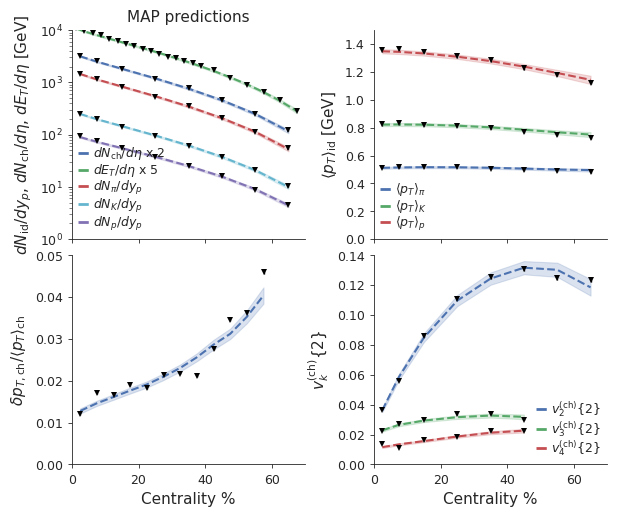

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 5), sharex=True)
axes =  axes.flatten()
for row, obs_group in enumerate(obs_groups.keys()):
    for obs, color in zip(obs_groups[obs_group], colors):
        expt_label = 'ALICE' if not do_validation else 'Validation obs'
        
        axes[row].tick_params(labelsize=9)

        scale = 1.0
        if obs_group == 'yields':
            axes[row].set_yscale('log')
            axes[row].set_title("MAP predictions", fontsize = 11)          
            if obs == 'dET_deta':
                scale = 5.
            if obs == 'dNch_deta':
                scale = 2.
        
        axes[row].set_ylabel(obs_group_labels[obs_group], fontsize = 11)
        
        xbins = np.array(obs_cent_list['Pb-Pb-2760'][obs])
        x = (xbins[:,0] + xbins[:,1]) / 2.

        label = obs_tex_labels[obs]    
        
        # MAP:
        Y1 = MAP_mean[index[obs][0]:index[obs][1]]
        Yerr1 = np.sqrt(MAP_var.diagonal()[index[obs][0]:index[obs][1]])    
        axes[row].plot(x, Y1*scale, '--', color = color, label = label, lw = 1.5)
        axes[row].fill_between(x, (Y1-Yerr1)*scale, (Y1+Yerr1)*scale, color=color, alpha=0.2)
        
          
        exp_mean = Yexp[index[obs][0]:index[obs][1]]
        exp_err = np.sqrt(Yvar[index[obs][0]:index[obs][1]])

        axes[row].errorbar(x, exp_mean*scale, exp_err, color='black', fmt='v', markersize='4', elinewidth=1)
        
    leg = axes[row].legend(fontsize=9, borderpad=0, labelspacing=0, handlelength=1, handletextpad=0.2)
    
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
        legobj.set_alpha(1.0)

    axes[row].set_xlim(0, 70)

    if obs_group == 'yields':
        axes[row].set_ylim(1, 1e4)
    if obs_group == 'mean_pT':
        axes[row].set_ylim(0., 1.5)
    if obs_group == 'fluct':
        axes[row].set_ylim(0.0, 0.05)
    if obs_group == 'flows':
        axes[row].set_ylim(0.0, 0.14)
    if axes[row].is_last_row():
        axes[row].set_xlabel('Centrality %', fontsize = 11)

plt.tight_layout(True)
set_tight(fig, rect=[0, 0, 1, 1])
save_fig("MAP_prediction")

### Posterior for the viscosities

[ 0.25015421 -0.15067507 -0.18580838  0.13378421]


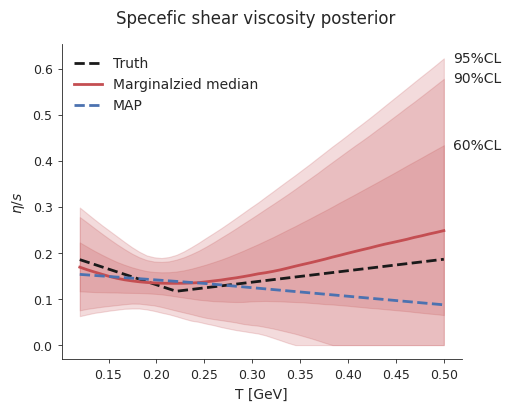

In [44]:
T = np.linspace(0.12, .5, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4),
                         sharex=False, sharey=False, constrained_layout=True)

fig.suptitle("Specefic shear viscosity posterior", wrap=True)


if do_validation:
    true_etas = eta_over_s(T, *Truth[7:11])
    ax.plot(T, true_etas, 'k--', label='Truth', lw=2)
print(Map_param[7:11])
posterior_etas = []
for row in samples_df.iloc[:,7:11].values:
    T_k, alow, ahigh, etas_k = row
    posterior_etas.append(eta_over_s(T, T_k ,alow, ahigh, etas_k))
posterior_etas = np.array(posterior_etas)

Median = np.percentile(posterior_etas, 50, axis=0)
ax.plot(T, Median, 'r-', label="Marginalzied median", lw=2)
ax.plot(T, eta_over_s(T, *Map_param[7:11]), 'b--', label='MAP', lw=2)
for CL in [60,90,95]:
    Low, High = np.percentile(posterior_etas, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(T, Low, High, alpha=0.2, color='r')
    ax.annotate("{}%CL".format(CL), xy=(T[-1]*1.02, High.max()), va="center", ha="left")

ax.legend(loc='upper left')
ax.set_xlabel('T [GeV]')
ax.set_ylabel('$\eta/s$')
save_fig('shear_pos_ptemcee')

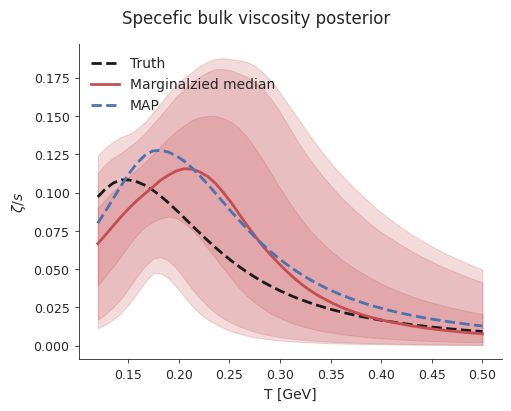

In [45]:
T = np.linspace(0.12, .5, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4),
                         sharex=False, sharey=False, constrained_layout=True)

fig.suptitle("Specefic bulk viscosity posterior", wrap=True)

if do_validation:
    true_zetas = zeta_over_s(T, *Truth[11:15])
    ax.plot(T, true_zetas, 'k--', label='Truth', lw=2)

posterior_zetas = []
for row in samples_df.iloc[:,11:15].values:
    T_k, alow, ahigh, etas_k = row
    posterior_zetas.append(zeta_over_s(T, T_k ,alow, ahigh, etas_k))
posterior_zetas = np.array(posterior_zetas)

Median = np.percentile(posterior_zetas, 50, axis=0)
ax.plot(T, Median, 'r-', label="Marginalzied median", lw=2)
ax.plot(T, zeta_over_s(T, *Map_param[11:15]), 'b--', label='MAP', lw=2)
for CL in [60,90,95]:
    Low, High = np.percentile(posterior_zetas, [50-CL/2., 50+CL/2.], axis=0)
    ax.fill_between(T, Low, High, alpha=0.2, color='r')

ax.legend(loc='upper left')
ax.set_xlabel('T [GeV]')
ax.set_ylabel('$\zeta/s$')
save_fig('bulk_pos_ptemcee')

### Exercise: over lay the posterior with the prior. Do all the features in the posterior come from experimental data constraints?

## Quantify the information gain using the Kullback–Leibler (K-L) divergence

You have seen that at certain temperatures, experimental data can reduce the prior band to a narrower posterior band; while in other regions (particularly the high-temperature region), the data do not provide much constraints. We can quantify this observation using the so-called Kullback–Leibler (K-L) divergence. 

Consider the prior and the posterior distribution of $\zeta/s$ at a certain temperature:

In [46]:
T = np.linspace(0.12, .5, 50)

u4 = np.random.rand(4, 500000)
Tk    =  0.13 * (1.-u4[0]) + 0.3 * u4[0]
alow  = - 2.0 * (1.-u4[1]) + 1.0 * u4[1] 
ahigh = - 1.0 * (1.-u4[2]) + 2.0 * u4[2] 
etask =  0.01 * (1.-u4[3]) + 0.2 * u4[3] 
prior_etas = np.array([eta_over_s(it, Tk, alow, ahigh, etask) for it in T]).T

zetasmax =  0.01 * (1.-u4[0]) + 0.2 * u4[0]
Tzeta  = 0.12 * (1.-u4[1]) + 0.3 * u4[1] 
wzeta = 0.025 * (1.-u4[2]) + 0.15 * u4[2] 
lambdazeta =  -0.8 * (1.-u4[3]) + 0.8 * u4[3] 
prior_zetas = np.array([zeta_over_s(it, zetasmax, Tzeta, wzeta, lambdazeta) for it in T]).T

T = 0.198 GeV


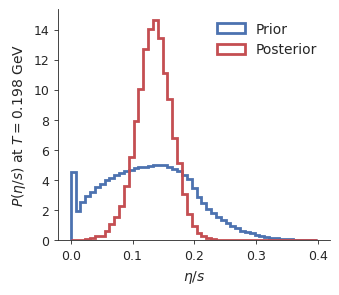

In [47]:
iT = 10
print("T = {:1.3f} GeV".format(T[iT]))
plt.figure(figsize=(3.5,3))
_ = plt.hist(prior_etas[:,iT], density=True, range=[0,prior_etas[:,iT].max()], bins=51, 
             histtype='step', color='b', lw=2, label="Prior")
_ = plt.hist(posterior_etas[:,iT], density=True, range=[0,prior_etas[:,iT].max()], bins=51, 
             histtype='step', color='r', lw=2, label="Posterior")
_ = plt.xlabel(r"$\eta/s$")
_ = plt.ylabel(r"$P(\eta/s)$ at $T={:1.3f}$ GeV".format(T[iT]))
plt.legend(loc='best')

Information gain $\Leftrightarrow$ How different are the two distributions (Prior v.s. Posterior).

The K-L divergence is a measure of the diference/distance of two distributions $P(x), Q(x)$,

$$D_{KL}(P||Q) = \int P(x)\ln \frac{P(x)}{Q(x)} dx > 0$$

Let's take $Q$ to be the posterior and $P$ to be the prior. We will use the histrogramed values to approxiamte the above integral

For example if P and Q are two Gaussian with parameters $\mu_P, \sigma_P$ and $\mu_Q, \sigma_Q$, then
$$D_{KL}(P||Q) = \frac{(\mu_P-\mu_Q)^2}{\sigma_Q^2} +  \frac{\sigma_P^2}{\sigma_Q^2}\left(1- \frac{\sigma_Q^2}{\sigma_P^2}\ln\frac{\sigma_P^2}{\sigma_Q^2}\right)-1 $$
It is easy to see that given a prior $Q$, the K-L divergence is only zero when the two parameters of P and Q matches (i.e., no extra information is gained in the posterior).
K-L divergence is large if
   - $\mu_P$ to be very different from $\mu_Q$, i.e., learned something less expected.
   - $\mu_P \ll \mu_Q$, i.e., learning something with more certainty.
   - $\mu_P > \mu_Q$, not allowed in our set-up...



In [48]:
@np.vectorize
def KL(iT, Y='etas', Nb=101):
    S0 = prior_etas[:,iT] if Y=='etas' else prior_zetas[:,iT]
    S1 = posterior_etas[:,iT]if Y=='etas' else posterior_zetas[:,iT]
    Max = S0.max()
    Hprior, bx = np.histogram(S0, density=True, bins=Nb, range=(0, Max))
    Hposterior, bx = np.histogram(S1, density=True, bins=Nb, range=(0, Max))
    dx = bx[1] - bx[0]
    return ( Hposterior * np.log(1e-20 + Hposterior/Hprior ) )[(Hposterior>0) & (Hprior >0)].sum() * dx

In [49]:
print("KL divergence at T=", T[iT], "GeV is", KL(iT))

KL divergence at T= 0.19755102040816325 GeV is 0.5558916588662768


 /usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning:invalid value encountered in true_divide


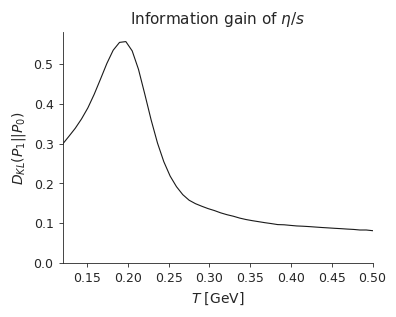

In [50]:
plt.figure(figsize=(4,3))
plt.plot(T, [KL(iT, 'etas') for iT, _ in enumerate(T)], 'k-')
plt.xlim(0.12, 0.5)
plt.ylim(ymin=0)
plt.xlabel(r"$T$ [GeV]")
plt.ylabel(r"$D_{KL}(P_1||P_0)$")
plt.title("Information gain of $\eta/s$")
save_fig("KL-etas")

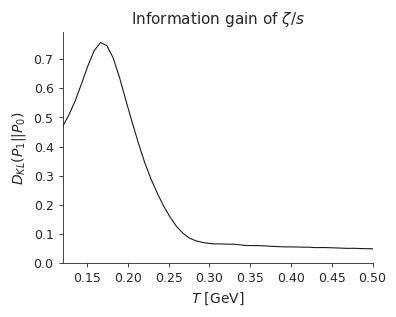

In [51]:
plt.figure(figsize=(4,3))
plt.plot(T, [KL(iT, 'zetas') for iT, _ in enumerate(T)], 'k-')
plt.xlim(0.12, 0.5)
plt.ylim(ymin=0)
plt.xlabel(r"$T$ [GeV]")
plt.ylabel(r"$D_{KL}(P_1||P_0)$")
plt.title("Information gain of $\zeta/s$")
save_fig("KL-zetas")

# What is not covered

> Emulator validation

> A full closure tests (all the 100 validation points to quantify the performance in the entire parameter space)

> MCMC convergence

> Predictive power of the calibrated model
